 10%|████▍                                       | 1/10 [00:00<00:03,  2.86it/s]

2.6666666666666665


 20%|████████▊                                   | 2/10 [00:00<00:02,  2.94it/s]

2.6666666666666665


 30%|█████████████▏                              | 3/10 [00:01<00:02,  2.95it/s]

2.6666666666666665


 40%|█████████████████▌                          | 4/10 [00:01<00:01,  3.01it/s]

2.6666666666666665


 60%|██████████████████████████▍                 | 6/10 [00:01<00:01,  3.06it/s]

2.6666666666666665
2.6666666666666665


 80%|███████████████████████████████████▏        | 8/10 [00:02<00:00,  3.11it/s]

2.6666666666666665
2.6666666666666665


 90%|███████████████████████████████████████▌    | 9/10 [00:02<00:00,  3.13it/s]

2.6666666666666665


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  3.07it/s]

2.6666666666666665


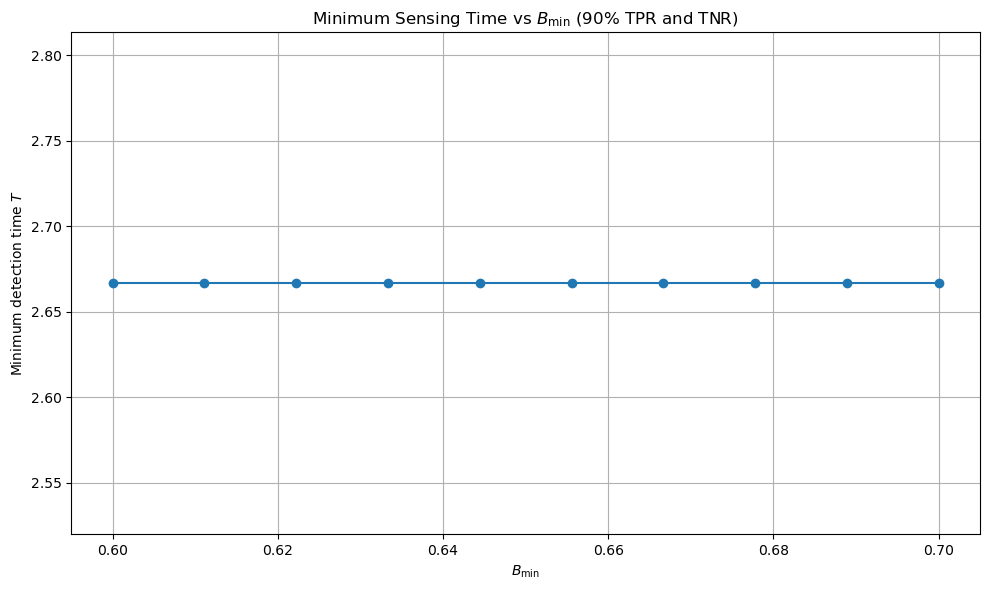

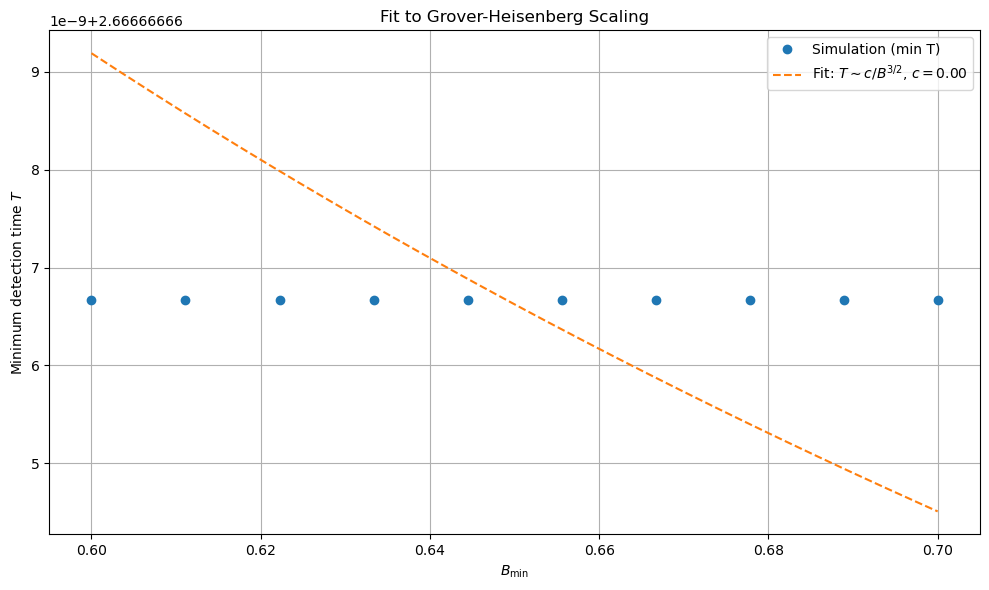

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm

# Parameters
B_min_values = np.linspace(.6,.7, 10)
T_values = np.linspace(2, 3.5, 10)
g = 1.0
steps = 100
omegas = np.linspace(0, 1, 10)
B_factors = [0, 1.0, 2.0]  # include null and signal cases

sx, sz = sigmax(), sigmaz()
psi0 = (basis(2, 0) + basis(2, 1)).unit()

def estimate_signal_strength(z_vals, x_vals):
    return np.std(z_vals) + np.std(x_vals)

# Output storage
min_time_for_B = []

# Loop over B_min values
for B_min in tqdm(B_min_values):
    success_T = None

    # Sweep time
    for T in T_values:
        times = np.linspace(0, T, steps)
        results = {}

        # Simulate for B = 0 and B = B_min, 2 B_min
        for B_mult in B_factors:
            B = B_mult * B_min
            estimates = []
            for omega in omegas:
                H = [g * sx, [sz, lambda t, args: B * np.cos(omega * t)]]
                result = mesolve(H, psi0, times, [], [sz, sx])
                z_vals, x_vals = result.expect[0], result.expect[1]
                est = estimate_signal_strength(z_vals, x_vals)
                estimates.append(est)
            results[B] = np.var(estimates)

        # Sweep threshold offsets
        baseline_var = results[0.0]
        threshold_offsets = np.linspace(-0.01, 0.1, 10)

        for offset in threshold_offsets:
            threshold = baseline_var + offset
            tp = tn = tp_total = tn_total = 0

            for B_mult in B_factors:
                B = B_mult * B_min
                var = results[B]
                decision = "H1" if var > threshold else "H0"
                if B_mult == 0:
                    tn_total += 1
                    if decision == "H0":
                        tn += 1
                elif B_mult >= 1.0:
                    tp_total += 1
                    if decision == "H1":
                        tp += 1

            tpr = tp / tp_total if tp_total else 0
            tnr = tn / tn_total if tn_total else 0
            if tpr >= 0.9 and tnr >= 0.9:
                success_T = T
                print(success_T)
                break  # No need to check more thresholds for this T

        if success_T:
            break  # Found minimum good T for this B_min

    min_time_for_B.append(success_T if success_T else np.nan)

# Plot time vs. B_min
plt.figure(figsize=(10, 6))
plt.plot(B_min_values, min_time_for_B, marker='o')
plt.xlabel("$B_{\\min}$")
plt.ylabel("Minimum detection time $T$")
plt.title("Minimum Sensing Time vs $B_{\\min}$ (90% TPR and TNR)")
plt.grid(True)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def ghl_model(B_min, c, d):
    return c / B_min**1.5 + d

# Fit model to data
valid = ~np.isnan(min_time_for_B)
B_fit = B_min_values[valid]
T_fit = np.array(min_time_for_B)[valid]
params, _ = curve_fit(ghl_model, B_fit, T_fit)
c_fit = params[0]

# Generate smooth curve for plot
B_smooth = np.linspace(min(B_fit), max(B_fit), 200)
T_smooth = ghl_model(B_smooth, *params)

# Plot original data and fit
plt.figure(figsize=(10, 6))
plt.plot(B_min_values, min_time_for_B, 'o', label='Simulation (min T)')
plt.plot(B_smooth, T_smooth, '--', label=f'Fit: $T \\sim c / B^{{3/2}}$, $c={c_fit:.2f}$')
plt.xlabel('$B_{\\min}$')
plt.ylabel('Minimum detection time $T$')
plt.title('Fit to Grover-Heisenberg Scaling')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



=== Running for 1 qubit(s) ===


100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  8.24it/s]


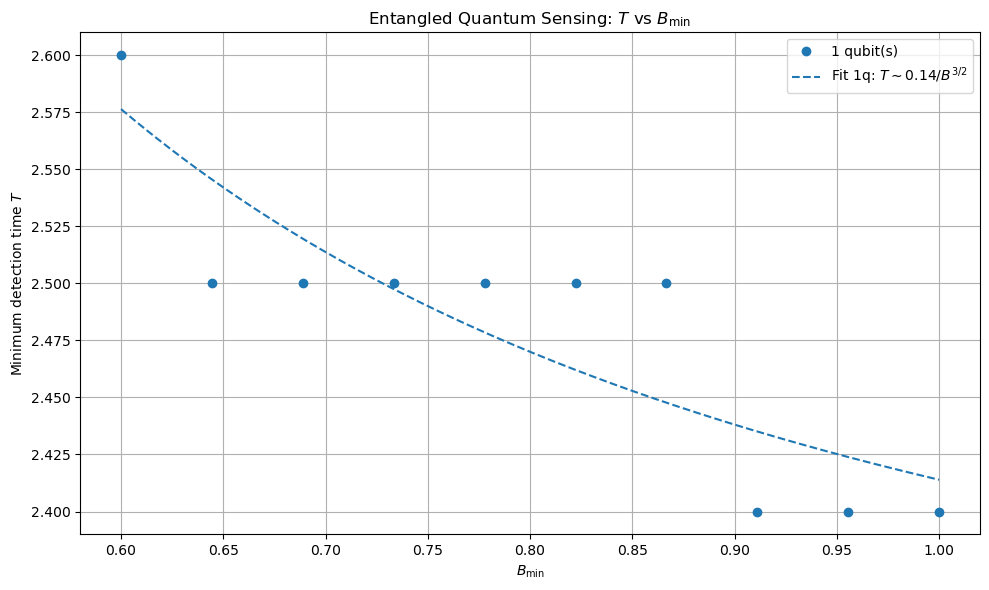

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from scipy.optimize import curve_fit

# Simulation parameters
B_min_values = np.linspace(0.6, 1, 10)
T_values = np.linspace(1.6, 3.5, 20)
g = 1.0
steps = 10
omegas = np.linspace(0, 1, 10)
B_factors = [0, 1.0, 2.0]
threshold_offsets = np.linspace(-0.01, 0.1, 10)

# Define n-qubit GHZ state
def ghz_state(n):
    return (tensor([basis(2, 0) for _ in range(n)]) + tensor([basis(2, 1) for _ in range(n)])).unit()

# Collective Pauli operators
def collective_op(op, n):
    return tensor([op for _ in range(n)])


def local_sum_op(single_qubit_op, n):
    """Return sum_i O_i where O acts on the i-th qubit (identity elsewhere)."""
    return sum([
        tensor([identity(2)] * i + [single_qubit_op] + [identity(2)] * (n - i - 1))
        for i in range(n)
    ])

# Signal strength estimator using ⟨Z⊗n⟩ and ⟨X⊗n⟩
def estimate_signal_strength(z_vals, x_vals):
    return np.std(z_vals) + np.std(x_vals)

# Grover-Heisenberg-like fit model
def ghl_model(B_min, c, d):
    return c / B_min**1.5 + d

# Run the simulation for multiple qubit sizes
qubit_counts = [3]
results_by_n = {}

for n_qubits in qubit_counts:
    print(f"\n=== Running for {n_qubits} qubit(s) ===")
    csx_n = collective_op(sigmax(), n_qubits)
    csz_n = collective_op(sigmaz(), n_qubits)
    sx_n = local_sum_op(sigmax(), n_qubits)
    sz_n = local_sum_op(sigmaz(), n_qubits)
    psi0 = ghz_state(n_qubits)
    min_time_for_B = []

    for B_min in tqdm(B_min_values):
        success_T = None

        for T in T_values:
            times = np.linspace(0, T, steps)
            results = {}

            for B_mult in B_factors:
                B = B_mult * B_min
                estimates = []

                for omega in omegas:
                    H0 = g * sx_n
                    H1 = [sz_n, lambda t, args: B * np.cos(omega * t)]
                    H = [H0, H1]
                    result = mesolve(H, psi0, times, [], [csz_n, csx_n])
                    z_vals, x_vals = result.expect[0], result.expect[1]
                    est = estimate_signal_strength(z_vals, x_vals)
                    estimates.append(est)

                results[B] = np.var(estimates)

            baseline_var = results[0.0]

            for offset in threshold_offsets:
                threshold = baseline_var + offset
                tp = tn = tp_total = tn_total = 0

                for B_mult in B_factors:
                    B = B_mult * B_min
                    var = results[B]
                    decision = "H1" if var > threshold else "H0"
                    if B_mult == 0:
                        tn_total += 1
                        if decision == "H0":
                            tn += 1
                    elif B_mult >= 1.0:
                        tp_total += 1
                        if decision == "H1":
                            tp += 1

                tpr = tp / tp_total if tp_total else 0
                tnr = tn / tn_total if tn_total else 0

                if tpr >= 0.9 and tnr >= 0.9:
                    success_T = T
                    break

            if success_T:
                break

        min_time_for_B.append(success_T if success_T else np.nan)

    results_by_n[n_qubits] = {
        "B_min_values": B_min_values.copy(),
        "min_times": np.array(min_time_for_B)
    }

# Plotting
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']
fits = {}

for i, n in enumerate(qubit_counts):
    B_vals = results_by_n[n]["B_min_values"]
    T_vals = results_by_n[n]["min_times"]
    valid = ~np.isnan(T_vals)
    B_fit = B_vals[valid]
    T_fit = T_vals[valid]
    
    # Fit
    popt, _ = curve_fit(ghl_model, B_fit, T_fit)
    B_smooth = np.linspace(min(B_fit), max(B_fit), 200)
    T_smooth = ghl_model(B_smooth, *popt)
    fits[n] = popt[0]

    plt.plot(B_vals, T_vals, 'o', label=f'{n} qubit(s)')
    plt.plot(B_smooth, T_smooth, '--', color=colors[i],
             label=f'Fit {n}q: $T \\sim {popt[0]:.2f} / B^{{3/2}}$')

plt.xlabel('$B_{\\min}$')
plt.ylabel('Minimum detection time $T$')
plt.title('Entangled Quantum Sensing: $T$ vs $B_{\\min}$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



=== Running for 1 qubit(s) ===


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.15it/s]



=== Running for 2 qubit(s) ===


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  3.78it/s]



=== Running for 3 qubit(s) ===


100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


[0.1209547  2.16026724]
[0.2000732 1.6589983]
[ 0.85521394 -0.09773707]


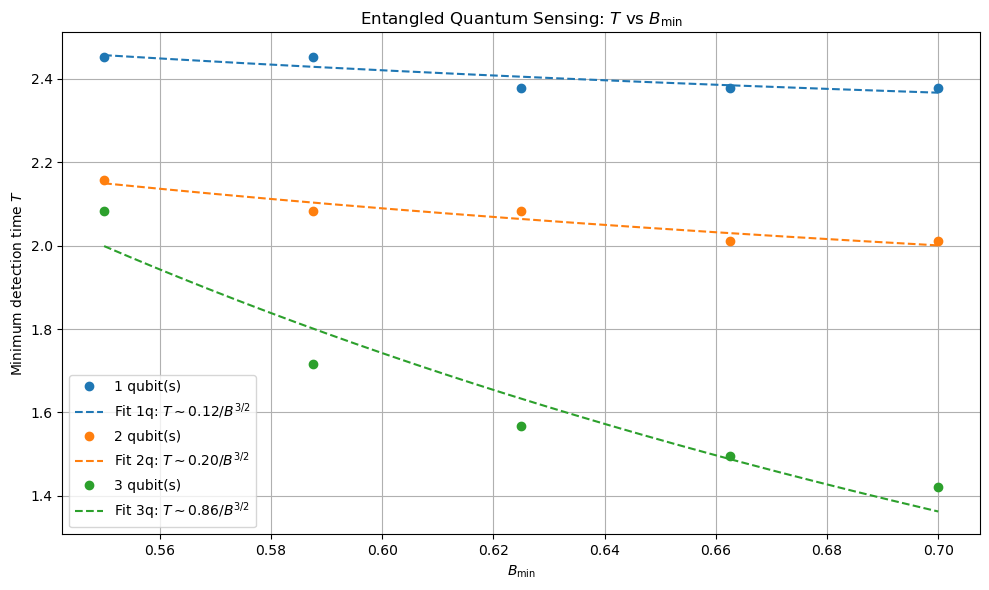

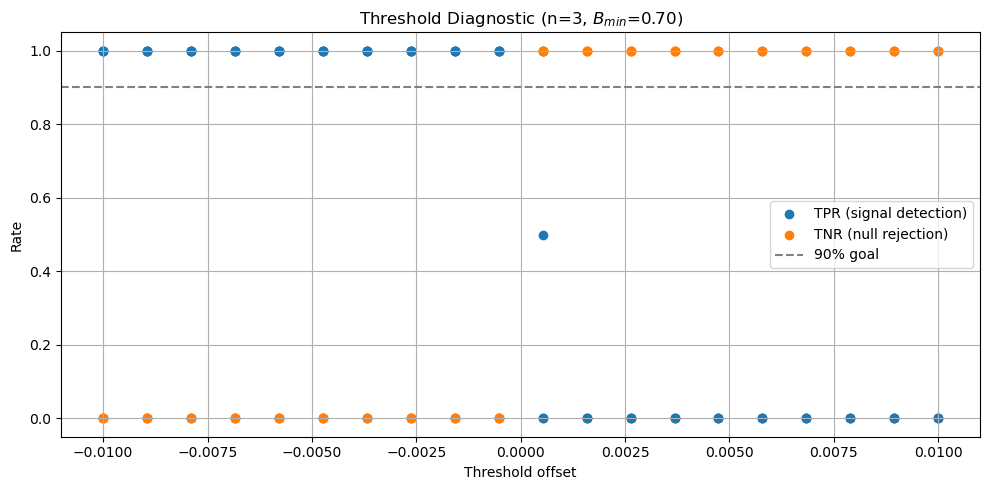

✅ Joint fit parameters:
    a = 0.3924
    d = 1.6300
    Model: T(B, n) = a / (n * B)^1.5 + d


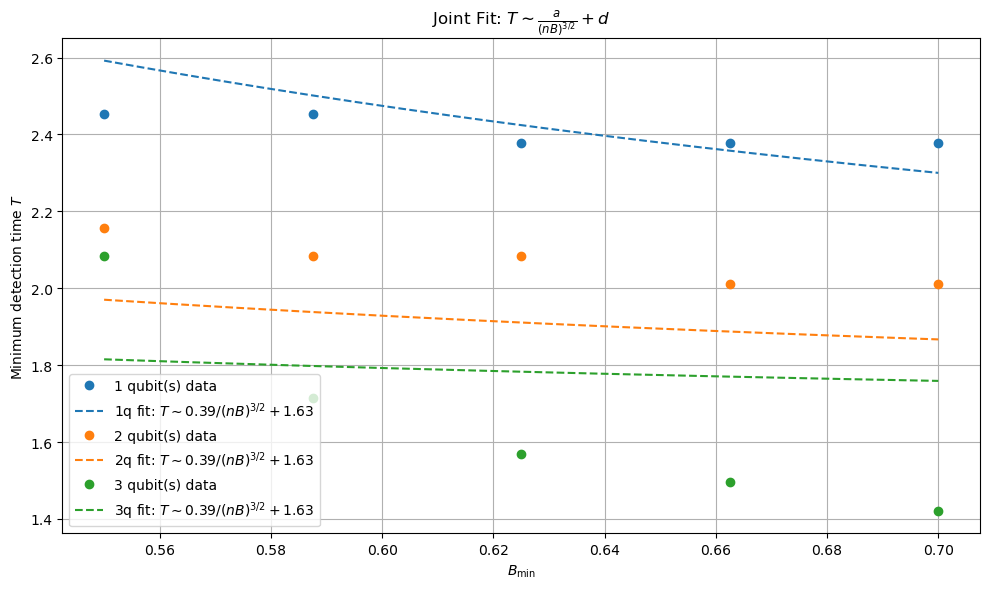

[-6.20822489e+08  1.00000000e+00  8.39377785e+00  1.00000000e+00
  2.20718064e+05]
✅ Improved joint fit parameters:
    a = -620822489.1122
    d = 1.0000
    e = 8.3938
    Model: T(B, n) = a / (n B)^1.5 + (d + e n)
[-6.20822489e+08  1.00000000e+00  8.39377785e+00  1.00000000e+00
  2.20718064e+05]


/var/folders/j0/gznjt10n4vsdfzmfxrnqn9hw0000gn/T/ipykernel_14462/3940164027.py:226: RuntimeWarning: invalid value encountered in power
  return a / (n * (B+g))**1.5 + (e/n)


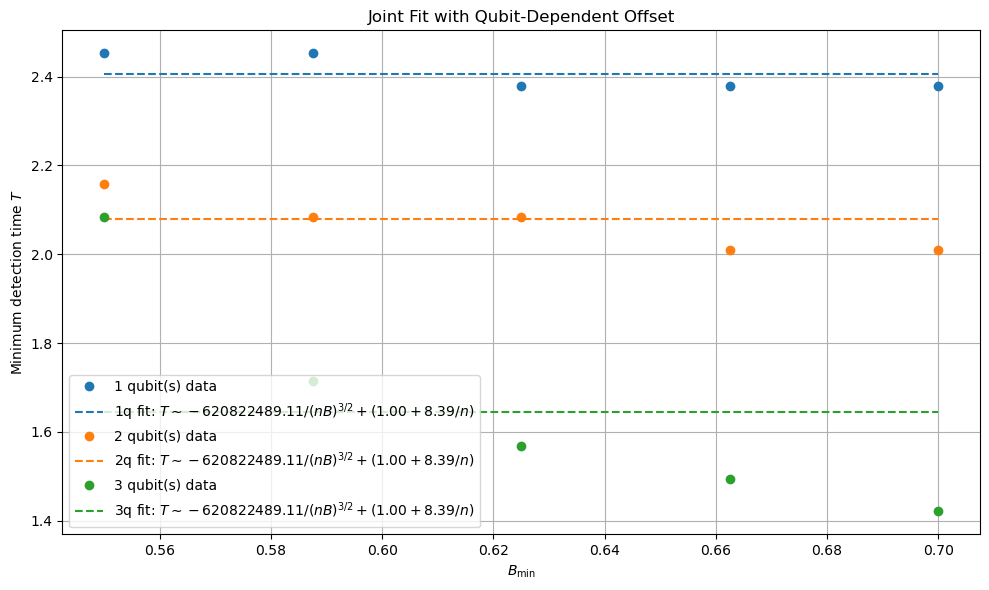

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from tqdm import tqdm
from scipy.optimize import curve_fit

# Simulation parameters
B_min_values = np.linspace(0.55, .7, 5)
T_values = np.linspace(1.2, 2.6, 20)
g = 1.0
steps = 20
omegas = np.linspace(0, 1, 10)
B_factors = [0, 1.0, 2.0]
threshold_offsets = np.linspace(-0.01, 0.01, 20)

# Define n-qubit GHZ state
def ghz_state(n):
    return (tensor([basis(2, 0) for _ in range(n)]) + tensor([basis(2, 1) for _ in range(n)])).unit()

def collective_op(op, n):
    return tensor([op for _ in range(n)])

def local_sum_op(op, n):
    return sum([tensor([identity(2)] * i + [op] + [identity(2)] * (n - i - 1)) for i in range(n)])

def estimate_signal_strength(z_vals, x_vals):
    return np.std(z_vals) + np.std(x_vals)

def ghl_model(B_min, c, d):
    return c / B_min**1.5 + d

# Run the simulation
qubit_counts = [1, 2, 3]
results_by_n = {}

for n_qubits in qubit_counts:
    print(f"\n=== Running for {n_qubits} qubit(s) ===")
    csx_n = collective_op(sigmax(), n_qubits)
    csz_n = collective_op(sigmaz(), n_qubits)
    sx_n = local_sum_op(sigmax(), n_qubits)
    sz_n = local_sum_op(sigmaz(), n_qubits)
    psi0 = ghz_state(n_qubits)
    min_time_for_B = []

    # Debug vars for last B_min
    last_TPRs = []
    last_TNRs = []
    last_offsets = []

    for B_min in tqdm(B_min_values):
        success_T = None
        last_results = {}

        for T in T_values:
            times = np.linspace(0, T, steps)
            results = {}

            for B_mult in B_factors:
                B = B_mult * B_min
                estimates = []
                for omega in omegas:
                    H0 = g * sx_n
                    H1 = [sz_n, lambda t, args: B * np.cos(omega * t)]
                    H = [H0, H1]
                    result = mesolve(H, psi0, times, [], [csz_n, csx_n])
                    z_vals, x_vals = result.expect[0], result.expect[1]
                    est = estimate_signal_strength(z_vals, x_vals)
                    estimates.append(est)
                results[B] = np.var(estimates)

            baseline_var = results[0.0]

            for offset in threshold_offsets:
                threshold = baseline_var + offset
                tp = tn = tp_total = tn_total = 0

                for B_mult in B_factors:
                    B = B_mult * B_min
                    var = results[B]
                    decision = "H1" if var > threshold else "H0"
                    if B_mult == 0:
                        tn_total += 1
                        if decision == "H0":
                            tn += 1
                    elif B_mult >= 1.0:
                        tp_total += 1
                        if decision == "H1":
                            tp += 1

                tpr = tp / tp_total if tp_total else 0
                tnr = tn / tn_total if tn_total else 0

                # Store for debugging the last B_min only
                if B_min == B_min_values[-1]:
                    last_TPRs.append(tpr)
                    last_TNRs.append(tnr)
                    last_offsets.append(offset)

                if tpr >= 0.9 and tnr >= 0.9:
                    success_T = T
                    break

            if success_T:
                break

        min_time_for_B.append(success_T if success_T else np.nan)

    results_by_n[n_qubits] = {
        "B_min_values": B_min_values.copy(),
        "min_times": np.array(min_time_for_B)
    }

# Main Plot: Minimum Detection Time vs B_min
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']
fits = {}

for i, n in enumerate(qubit_counts):
    B_vals = results_by_n[n]["B_min_values"]
    T_vals = results_by_n[n]["min_times"]
    valid = ~np.isnan(T_vals)
    B_fit = B_vals[valid]
    T_fit = T_vals[valid]

    # Fit
    popt, _ = curve_fit(ghl_model, B_fit, T_fit)
    B_smooth = np.linspace(min(B_fit), max(B_fit), 200)
    T_smooth = ghl_model(B_smooth, *popt)
    fits[n] = popt[0]

    plt.plot(B_vals, T_vals, 'o', label=f'{n} qubit(s)')
    plt.plot(B_smooth, T_smooth, '--', color=colors[i % len(colors)],
             label=f'Fit {n}q: $T \\sim {popt[0]:.2f} / B^{{3/2}}$')
    print(popt)

plt.xlabel('$B_{\\min}$')
plt.ylabel('Minimum detection time $T$')
plt.title('Entangled Quantum Sensing: $T$ vs $B_{\\min}$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Debug Plot: TPR/TNR vs threshold for last B_min
plt.figure(figsize=(10, 5))
plt.scatter(last_offsets, last_TPRs, marker='o', label='TPR (signal detection)')
plt.scatter(last_offsets, last_TNRs, marker='o', label='TNR (null rejection)')
plt.axhline(0.9, color='gray', linestyle='--', label='90% goal')
plt.xlabel("Threshold offset")
plt.ylabel("Rate")
plt.title(f"Threshold Diagnostic (n={n_qubits}, $B_{{min}}$={B_min_values[-1]:.2f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === Joint Fit: T = a / (n * B)^{3/2} + d ===

# Combine all data
all_B = []
all_T = []
all_n = []

for n in qubit_counts:
    B_vals = results_by_n[n]["B_min_values"]
    T_vals = results_by_n[n]["min_times"]
    valid = ~np.isnan(T_vals)
    all_B.extend(B_vals[valid])
    all_T.extend(T_vals[valid])
    all_n.extend([n] * sum(valid))

all_B = np.array(all_B)
all_T = np.array(all_T)
all_n = np.array(all_n)

# Define the joint fit model
def joint_model(X, a, d):
    B, n = X
    return a / (n * B)**1.5 + d

# Fit
popt, _ = curve_fit(joint_model, (all_B, all_n), all_T)
a_fit, d_fit = popt

# Print fit result
print(f"✅ Joint fit parameters:")
print(f"    a = {a_fit:.4f}")
print(f"    d = {d_fit:.4f}")
print(f"    Model: T(B, n) = a / (n * B)^1.5 + d")

# Plot fit overlay
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, n in enumerate(qubit_counts):
    B_vals = results_by_n[n]["B_min_values"]
    T_vals = results_by_n[n]["min_times"]
    valid = ~np.isnan(T_vals)
    B_fit = B_vals[valid]
    T_fit = T_vals[valid]

    B_smooth = np.linspace(min(B_fit), max(B_fit), 200)
    T_smooth = joint_model((B_smooth, np.full_like(B_smooth, n)), *popt)

    plt.plot(B_fit, T_fit, 'o', label=f'{n} qubit(s) data')
    plt.plot(B_smooth, T_smooth, '--', color=colors[i % len(colors)],
             label=f'{n}q fit: $T \\sim {a_fit:.2f}/(nB)^{{3/2}} + {d_fit:.2f}$')

plt.xlabel('$B_{\\min}$')
plt.ylabel('Minimum detection time $T$')
plt.title('Joint Fit: $T \\sim \\frac{a}{(n B)^{3/2}} + d$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Improved Joint Fit: T = a / (n * B)^{3/2} + (d + e * n) ===

# Reuse data from earlier
# all_B, all_T, all_n already defined in previous block

# Define improved model
def improved_joint_model(X, a, d, e, f, g):
    B, n = X
    return a / (n * (B+g))**1.5 + (e/n)

# Fit
popt_improved, _ = curve_fit(improved_joint_model, (all_B, all_n), all_T, maxfev=10000)
a_fit, d_fit, e_fit, f_fit, g_fit = popt_improved
print(popt_improved)

# Print results
print(f"✅ Improved joint fit parameters:")
print(f"    a = {a_fit:.4f}")
print(f"    d = {d_fit:.4f}")
print(f"    e = {e_fit:.4f}")
print(f"    Model: T(B, n) = a / (n B)^1.5 + (d + e n)")

# Plot results
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green']

for i, n in enumerate(qubit_counts):
    B_vals = results_by_n[n]["B_min_values"]
    T_vals = results_by_n[n]["min_times"]
    valid = ~np.isnan(T_vals)
    B_fit = B_vals[valid]
    T_fit = T_vals[valid]

    B_smooth = np.linspace(min(B_fit), max(B_fit), 200)
    T_smooth = improved_joint_model((B_smooth, np.full_like(B_smooth, n)), *popt_improved)

    plt.plot(B_fit, T_fit, 'o', label=f'{n} qubit(s) data')
    plt.plot(B_smooth, T_smooth, '--', color=colors[i % len(colors)],
             label=f'{n}q fit: $T \\sim {a_fit:.2f}/(nB)^{{3/2}} + ({d_fit:.2f} + {e_fit:.2f}/n)$')
print(popt_improved)
plt.xlabel('$B_{\\min}$')
plt.ylabel('Minimum detection time $T$')
plt.title('Joint Fit with Qubit-Dependent Offset')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Simulation Parameters
T = 5.0
steps = 1000
times = np.linspace(0, T, steps)
g = 1.0
delta_omega = [0.2, 0.4, 0.6, 0.8, 1.0]
omegas = np.linspace(0, 1, 15)
B_factors = [0, 0.5, 1, 1.5, 2, 2.5, 3]

# Qubit setup
sx, sz = sigmax(), sigmaz()
psi0 = (basis(2, 0) + basis(2, 1)).unit()

def estimate_signal_strength(z_vals, x_vals):
    return np.std(z_vals) + np.std(x_vals)

# Run simulation
results = {}
for B_min in delta_omega:
    results[B_min] = {}
    for B_mult in B_factors:
        B = B_mult * B_min
        estimates = []
        for omega in omegas:
            H = [g * sx, [sz, lambda t, args: B * np.cos(omega * t)]]
            result = mesolve(H, psi0, times, [], [sz, sx])
            z_vals, x_vals = result.expect[0], result.expect[1]
            est = estimate_signal_strength(z_vals, x_vals)
            estimates.append(est)
        avg, var = np.mean(estimates), np.var(estimates)
        results[B_min][B] = {"mean": avg, "var": var}

# Threshold sweep
threshold_offsets = np.linspace(-0.01, 0.05, 50)
true_positive_rates = []
true_negative_rates = []
optimal_threshold = None

for offset in threshold_offsets:
    tp = tn = tp_total = tn_total = 0

    for B_min in delta_omega:
        baseline_var = results[B_min][0.0]["var"]
        threshold = baseline_var + offset

        for B_mult in B_factors:
            B = B_mult * B_min
            var = results[B_min][B]["var"]
            decision = "H1" if var > threshold else "H0"

            if B_mult == 0:
                tn_total += 1
                if decision == "H0":
                    tn += 1
            elif B_mult >= 1.0:
                tp_total += 1
                if decision == "H1":
                    tp += 1

    tpr = tp / tp_total if tp_total else 0
    tnr = tn / tn_total if tn_total else 0
    true_positive_rates.append(tpr)
    true_negative_rates.append(tnr)

    if optimal_threshold is None and tpr >= 0.9 and tnr >= 0.9:
        optimal_threshold = offset

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(threshold_offsets, true_positive_rates, label="True Positive Rate (B ≥ B_min)", marker='o')
plt.plot(threshold_offsets, true_negative_rates, label="True Negative Rate (B = 0)", marker='o')
if optimal_threshold is not None:
    plt.axvline(optimal_threshold, color='gray', linestyle='--', label=f"Optimal threshold = {optimal_threshold:.3f}")
plt.xlabel("Threshold offset (added to baseline variance)")
plt.ylabel("Accuracy")
plt.title("Hypothesis Test Accuracy vs Threshold Offset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if optimal_threshold is not None:
    print(f"✅ Optimal threshold offset: {optimal_threshold:.5f}")
else:
    print("❌ No threshold found where both TPR and TNR ≥ 90%")
